# ATSC-500 Assignment V (Turbulent flux budget)

In [1]:
import textwrap
import numpy as np
import netCDF4 as nc
from glob import glob
from os.path import basename
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline

In [2]:
names = sorted(glob('_data/ATSC-500/mar12014*.nc'))
names = names[1:6] # <---------- !! cut flie numbers
[print(name) for name in names];

_data/ATSC-500/mar12014_1_15600.nc
_data/ATSC-500/mar12014_2_15600.nc
_data/ATSC-500/mar12014_3_15600.nc
_data/ATSC-500/mar12014_4_15600.nc
_data/ATSC-500/mar12014_5_15600.nc


In [3]:
L = len(names)
z_cut =  100 # <---------- !! cut vertical levels
shape_grid = (L,) + (z_cut, 128, 192)

P = np.ones(shape_grid)
time = np.zeros(L)*np.nan
U = np.zeros(shape_grid)*np.nan
V = np.zeros(shape_grid)*np.nan
W = np.zeros(shape_grid)*np.nan
T = np.zeros(shape_grid)*np.nan
PP = np.zeros(shape_grid)*np.nan
RMIX = np.zeros(shape_grid)*np.nan

for i, name in enumerate(names):
    nc_obj = nc.Dataset(name)
    for j in range(z_cut):
        P[i, j, ...] = P[i, j, ...]*nc_obj.variables['p'][j, ...]*1e-2 # hPa -> Pa
    time[i] = nc_obj.variables['time'][...]
    U[i, ...] = nc_obj.variables['U'][0, :z_cut, ...]
    V[i, ...] = nc_obj.variables['V'][0, :z_cut, ...]
    W[i, ...] = nc_obj.variables['W'][0, :z_cut, ...]
    T[i, ...] = nc_obj.variables['TABS'][0, :z_cut, ...]
    PP[i, ...] = nc_obj.variables['PP'][0, :z_cut, ...]
    RMIX[i, ...] = nc_obj.variables['QV'][0, :z_cut, ...]*1e-3 # g/kg -> kg/kg

## Assignment - produce a vapor visualization for a Chapter 4 variance

I choose to produce the budget terms for turbulent v-component momentum flux. Recalling Stull eq.(4.4.1.a):

$$
\frac{d\overline{u^{'}_i u^{'}_k}}{dt} = -\left[(\overline{u_i^{'}u_j^{'}})\frac{\partial\overline{u_k}}{\partial x_j}+(\overline{u_k^{'}u_j^{'}})\frac{\partial\overline{u_i}}{\partial x_j}\right] - \frac{\partial\left(u_i^{'}u_j^{'}u_k^{'}\right)}{\partial x_j}+\frac{g}{\overline{\theta_v}}\left(\delta_{k3}\overline{u_i^{'}\theta_v^{'}}+\delta_{i3}\overline{u_k^{'}\theta_v^{'}}\right)+f_c\left(\epsilon_{kj3}\overline{u_i^{'}u_j^{'}}+\epsilon_{ij3}\overline{u_k^{'}u_j^{'}}\right)-\frac{1}{\overline{\rho}}\left[\frac{\partial\overline{p^{'}u_k^{'}}}{\partial x_i}+\frac{\partial\overline{p^{'}u_i^{'}}}{\partial x_k} - \overline{p^{'}\left(\frac{\partial u_i^{'}}{\partial x_k}+\frac{\partial u_k^{'}}{\partial x_i}\right)}\right] + \mu\frac{\partial^2 u_i^{'}u_k^{'}}{\partial x_j^2} - 2\mu\frac{\overline{\partial u_i^{'}\partial x_k^{'}}}{\partial x_j^2}
$$

Term III, IV, V, VI, VIII (see Stull page 136) will be calculated in one of the experiment.

In [4]:
# Choosing mar12014_10_15600.nc as an example
# coords
x = nc_obj.variables['x'][...]
y = nc_obj.variables['y'][...]
z = nc_obj.variables['z'][:z_cut]
Y, Z, X = np.meshgrid(y, z, x)

_, _, dx = np.gradient(X, edge_order=2)
_, dy, _ = np.gradient(Y, edge_order=2)
dz, _, _ = np.gradient(Z, edge_order=2)

In [5]:
U_mean = U.mean(axis=0)
V_mean = V.mean(axis=0)
W_mean = W.mean(axis=0)

dUz, dUy, dUx = np.gradient(U_mean, edge_order=2)
dVz, dVy, dVx = np.gradient(V_mean, edge_order=2)
dWz, dWy, dWx = np.gradient(W_mean, edge_order=2)

### Term III

$$
(\overline{v^{'}u^{'}})\frac{\partial \overline{W}}{\partial x} + (\overline{v^{'}v^{'}})\frac{\partial \overline{W}}{\partial y} +(\overline{v^{'}w^{'}})\frac{\partial \overline{W}}{\partial z} +(\overline{w^{'}u^{'}})\frac{\partial \overline{V}}{\partial x} +(\overline{w^{'}v^{'}})\frac{\partial \overline{V}}{\partial y} +(\overline{w^{'}w^{'}})\frac{\partial \overline{V}}{\partial z}
$$

In [6]:
VU_mean = np.mean((V - V_mean)*(U - U_mean), 0)
VV_mean = np.mean((V - V_mean)*(V - V_mean), 0)
VW_mean = np.mean((V - W_mean)*(V - W_mean), 0)

WU_mean = np.mean((W - W_mean)*(U - U_mean), 0)
WV_mean = VW_mean
WW_mean = np.mean((W - W_mean)*(W - W_mean), 0)

In [7]:
term3 = VU_mean*(dWx/dx) + VV_mean*(dWy/dy) + VW_mean*(dWz/dz) + \
        WU_mean*(dVx/dx) + WV_mean*(dVy/dy) + WW_mean*(dVz/dz)
    
#term3 = -1*term3

In [8]:
VUW = np.mean((V - V_mean)*(U - U_mean)*(W - W_mean), 0)
VVW = np.mean((V - V_mean)*(V - V_mean)*(W - W_mean), 0)
VWW = np.mean((U - U_mean)*(V - V_mean)*(W - W_mean), 0)

_, _, d_VUWx = np.gradient(VUW, edge_order=2)
_, d_VVWy, _ = np.gradient(VVW, edge_order=2)
d_VWWz, _, _ = np.gradient(VWW, edge_order=2)

### Term IV

$$
\frac{\partial \overline{u^{'}v^{'}w^{'}}}{\partial x} + \frac{\partial \overline{v^{'}v^{'}w^{'}}}{\partial y} + \frac{\partial \overline{v^{'}w^{'}w^{'}}}{\partial z}
$$

In [9]:
term4 = d_VUWx/dx + d_VVWy/dy + d_VWWz/dz
#term4 = -1*term4

In [10]:
P_mean = P.mean(axis=0)
T_mean = T.mean(axis=0)
RMIX_mean = RMIX.mean(axis=0)

def theta_v(T, P, RMIX):
    theta = T*(1000/P)**(0.286)
    return theta*(1+0.608*RMIX)

theta = theta_v(T, P_mean+PP[0, ...], RMIX)
theta_mean = theta_v(T_mean, P_mean, RMIX_mean)
V_theta_mean = np.mean((V-V_mean)*(theta-theta_mean), 0)

### Term V

$$
\frac{g}{\overline{\theta_v}}\left(\overline{v^{'}\theta_v^{'}}\right)
$$

In [11]:
g = 9.8
term5 = (g/theta_mean)*V_theta_mean

### Term VI

$$
f_c\left(\overline{u^{'}w^{'}}\right)
$$

In [12]:
fc = 1e-4 # f(\phi) = 2\omiga sin\phi
term6 = fc*WU_mean

### Term VIII

$$
\overline{\frac{p^{'}}{\overline{\rho}}\left(\frac{\partial v^{'}}{\partial z}+\frac{\partial w^{'}}{\partial y}\right)}
$$


In [13]:
rho_mean = 1.225 # for approx

V_anom = V - V_mean
W_anom = W - W_mean

what, d_V_anom_z, _, _ = np.gradient(V_anom, edge_order=2)
_, _, d_W_anom_y, _ = np.gradient(W_anom, edge_order=2)

term8 = np.mean(PP/(rho_mean)*(d_V_anom_z/dz+d_W_anom_y/dy), 0)

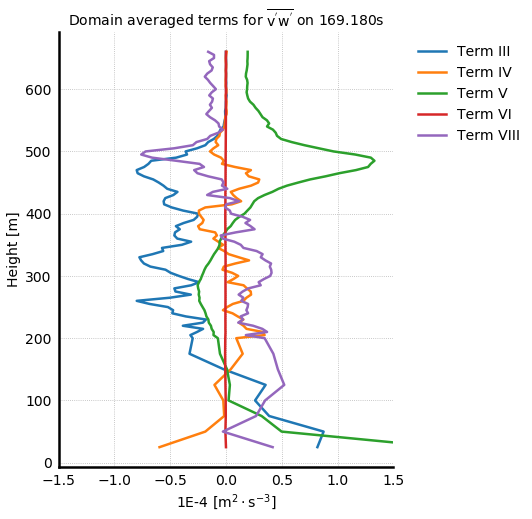

In [14]:
fig = plt.figure(figsize=(6, 8))
ax = fig.gca()
ax.grid(linestyle=':')
ax.set_xlim([-1.5, 1.5])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[j.set_linewidth(2.5) for j in ax.spines.values()]
ax.tick_params(axis="both", which="both", bottom="off", top="off", \
       labelbottom="on", left="off", right="off", labelleft="on")
ax.set_ylabel('Height [m]', fontsize=14)
ax.set_xlabel('1E-4 [$\mathrm{m^2\cdot s^{-3}}$]', fontsize=14)
ax.set_title("Domain averaged terms for $\mathrm{\overline{v^{'}w^{'}}}$ on "+(str(time[0])[:7])+'s', fontsize=14)
ax.plot(np.mean(term3, (1, 2))*1e4, z, lw=2.5, label='Term III')
ax.plot(np.mean(term4, (1, 2))*1e4, z, lw=2.5, label='Term IV')
ax.plot(np.mean(term5, (1, 2))*1e4, z, lw=2.5, label='Term V')
ax.plot(np.mean(term6, (1, 2))*1e4, z, lw=2.5, label='Term VI')
ax.plot(np.mean(term8, (1, 2))*1e4, z, lw=2.5, label='Term VIII')

LG = ax.legend(bbox_to_anchor=(1.035, 1), prop={'size':14}); LG.draw_frame(False)

## Calculate v'w'

In [15]:
VW_anom = (V - W_mean)*(V - W_mean)
VW_ave = np.mean(VW_anom,(2, 3))

In [24]:
# fig, AX = plt.subplots(1, 5, figsize=(10, 6))
# AX = AX.flat
# for i, ax in enumerate(AX):
#     ax.grid(linestyle=':')
#     ax.set_xlim([-0.1, 0.4])
#     ax.spines["top"].set_visible(False)
#     ax.spines["left"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.xaxis.set_tick_params(labelsize=14)
#     ax.yaxis.set_tick_params(labelsize=14)
#     [j.set_linewidth(2.5) for j in ax.spines.values()]
#     ax.tick_params(axis="both", which="both", bottom="off", top="off", \
#            labelbottom="on", left="off", right="off", labelleft="off")
#     ax.set_title('Ensemble {}'.format(i+1), fontsize=14)

# AX[0].set_ylabel('Height [m]', fontsize=14)
# AX[0].spines["left"].set_visible(True)
# AX[0].tick_params(labelleft="on")
# for i in range(L):
#     AX[i].plot(VW_ave[i, :], z, lw=3)

## Convert np.arry into vdf

In [21]:
filenames = ['_data/ATSC-500/xvals.txt', '_data/ATSC-500/yvals.txt', '_data/ATSC-500/zvals.txt']
arrays = [x, y, z]
for name, vals in zip(filenames, arrays):
    print (type(vals))
    with open(name, 'w') as outfile:
        #
        # write all but the last without a newline
        #
        [outfile.write('{:6.3f} '.format(item)) for item in vals[:-1]]
        #
        # write the last value with a newline
        #
        outfile.write('{:6.3f}\n'.format(vals[-1]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [22]:
varname = 'vflux'
out_name = '_data/ATSC-500/{}.bin'.format(varname)
rev_shape = VW_anom[0, ...].shape[::-1]
string_shape="{}x{}x{}".format(*rev_shape)
print('writing an array of {} of shape x,y,z= {}'.format(varname, string_shape))
fp = np.memmap(out_name, dtype=np.float32,
               mode='w+', shape=VW_anom[0, ...].shape)
fp[...] = VW_anom[0, ...]*1e2

writing an array of vflux of shape x,y,z= 192x128x100


In [23]:
vars=dict(dim=string_shape,var='vflux')
    
command=r"""
    . /home/yingkai/vapor/vapor-2.6.0/bin/vapor-setup.sh
    
    vdfcreate  -xcoords xvals.txt -ycoords yvals.txt -zcoords zvals.txt \
       -gridtype stretched -dimension {dim:s} -vars3d {var:s} -numts 1 {var:s}.vdf

    raw2vdf -varname {var:s} -ts 0 {var:s}.vdf {var:s}.bin
"""
out=textwrap.dedent(command.format_map(vars))
with open('_data/ATSC-500/make_vapor.sh','w') as f:
    f.write('#!/bin/bash -v\n')
    f.write(out)